In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train, x_test = x_train/255.0 *2-1 ,x_test/255.0 *2-1
print(x_train.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


In [3]:
N,H,W=x_train.shape
D=H*W
x_train=x_train.reshape(-1,D)
x_test=x_test.reshape(-1,D)
print(x_train.shape)

(60000, 784)


In [4]:
latent_dim=100

In [5]:
def build_gen(latent_dim):
  i=Input(shape=(latent_dim,))
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(D,activation='tanh')(x)

  model=Model(i,x)
  return model


In [6]:
def build_des(img_size):
  i=Input(shape=(img_size,))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(x)
  x=Dense(1,activation='sigmoid')(x)
  
  model=Model(i,x)
  return model
  

In [7]:
d=build_des(D)
d.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5),metrics=['accuracy'])

g=build_gen(latent_dim)

noise=Input(shape=(latent_dim,))
img=g(noise)
d.trainable=False
fake_pred=d(img)

comb_model=Model(noise,fake_pred)
comb_model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))


In [8]:
#gen

batch_size=32
epochs=30000
sample_period=200 #every 200 steps gen and save some data 

ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

d_losses=[]
g_losses=[]

if not os.path.exists('gan_imgs'):
  os.makedirs('gan_imgs')

In [9]:
def sample_imgs(epoch):
  rows,cols=5,5
  noise=np.random.randn(rows*cols,latent_dim)
  imgs=g.predict(noise)

  #rescale 0-1
  imgs=0.5*imgs+0.5

  fig,axs =plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig('gan_imgs/%d.png' % epoch)
  plt.close

In [10]:
#main training 

for epoch in range(epochs):

  #dis
  
  #real imgs
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]

  #fake imgs
  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=g.predict(noise)

  d_loss_real,d_acc_real=d.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake=d.train_on_batch(fake_imgs,zeros)
  d_loss=0.5 *(d_loss_real+d_loss_fake)
  d_acc=0.5 *(d_acc_real+d_acc_fake)


  #gen
  noise=np.random.randn(batch_size,latent_dim)
  g_loss=comb_model.train_on_batch(noise,ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch%100==0:
    print(epoch+1,d_loss,d_acc,g_loss)
  
  if(epoch%sample_period == 0):
      sample_imgs(epoch)

                                          




Output hidden; open in https://colab.research.google.com to view.

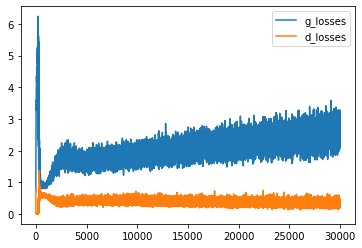

In [11]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()

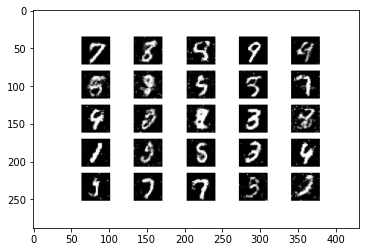

In [18]:
from skimage.io import imread 
a=imread('gan_imgs/29800.png')
plt.imshow(a)

In [ ]:
#  machine learning mastery 

# # define the standalone discriminator model
# def define_discriminator(in_shape=(28,28,1)): # 28,28 , channels to be add
#  model = Sequential()
#  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
#  model.add(LeakyReLU(alpha=0.2))
#  model.add(Dropout(0.4))
#  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
#  model.add(LeakyReLU(alpha=0.2))
#  model.add(Dropout(0.4))
#  model.add(Flatten())
#  model.add(Dense(1, activation='sigmoid'))
#  # compile model
#  opt = Adam(lr=0.0002, beta_1=0.5)
#  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#  return model
 
# # define the standalone generator model
# def define_generator(latent_dim):
#  model = Sequential()
#  # foundation for 7x7 image
#  n_nodes = 128 * 7 * 7 #
#  model.add(Dense(n_nodes, input_dim=latent_dim))
#  model.add(LeakyReLU(alpha=0.2))
#  model.add(Reshape((7, 7, 128)))
#  # upsample to 14x14
#  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#  model.add(LeakyReLU(alpha=0.2))
#  # upsample to 28x28
#  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#  model.add(LeakyReLU(alpha=0.2))
#  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
#  return model